<a href="https://colab.research.google.com/github/kimallix/lesson1/blob/main/Churn_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача проекта - прогнозирование оттока клиентов Телеком

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг:

1.	Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2.	Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
* Выделенная линия технической поддержки (*TechSupport*);
* Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
* Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


## Описание данных

Данные состоят из файлов, полученных из разных источников:
*	contract.csv — информация о договоре;
*	personal.csv — персональные данные клиента;
*	internet.csv — информация об интернет-услугах;
*	phone.csv — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


### Обозначения признаков

* `BeginDate` – дата начала пользования услугами, 
* `EndDate` – дата окончания пользования услугами, 
* `Type` – тип оплаты: ежемесячный, годовой и тд, 
* `PaperlessBilling` – безналичный расчет, 
* `PaymentMethod` – способ оплаты, 
* `MonthlyCharges` – ежемесячные траты на услуги, 
* `TotalCharges` – всего потрачено денег на услуги 
* `Dependents` – наличие иждивенцев
* `Senior Citizen` – наличие пенсионного статуса по возрасту
* `Partner` – наличие супруга(и)
* `MultipleLines` – наличие возможности ведения параллельных линий во время звонка

## Критерии оценки работы

Основная метрика: `AUC-ROC > 0.8`. 

Дополнительная метрика: `Accuracy > 0.75`.


## Этап 1. Подготовка и предварительный анализ данных

In [ ]:
pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Загрузим необходимые библиотеки и инструменты
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Прочитаем файлы с данными и изучим их
from google.colab import drive
drive.mount('/content/drive')
contract_df = pd.read_csv('/content/drive/My Drive/contract.csv')
internet_df = pd.read_csv('/content/drive/My Drive/internet.csv')
personal_df = pd.read_csv('/content/drive/My Drive/personal.csv')
phone_df = pd.read_csv('/content/drive/My Drive/phone.csv')
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Для просмотра информации в файлах используем функцию present
def present(data):
    display(data.head())
    display(data.info())
    print('Количество пропусков')
    display(data.isnull().sum())
    print('Количество дубликатов')
    display(data.duplicated().sum())

### Информация о контрактах

In [ ]:
present(contract_df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Количество пропусков


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Количество дубликатов


0

В датасете с информацией о договоре пропущенных значений и дубликатов нет. Столбцы BeginDate и EndDate необходимо привести к типу `datetime`, столбец `TotalCharges` приведем к типу `float`.

In [ ]:
contract_df['BeginDate']=contract_df['BeginDate'].astype('datetime64')

In [ ]:
contract_df['BeginDate'].unique()

array(['2020-01-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2016-05-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2017-07-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2018-10-01T00:00:00.000000000',
       '2015-04-01T00:00:00.000000000', '2015-09-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2014-05-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000', '2014-03-01T00:00:00.000000000',
       '2018-05-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-02-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2017-08-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2014-02-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000', '2017-11-01

Среди уникальных записей даты окончания пользования услугами только четыре даты: первое число последних четырех месяцев перед выгрузкой базы. Скорее всего, оценка оттока клиентов проводится ежемесячно на первое число. Т.к. на дату выгрузки данных (01.02.2020) информации об оттоке клиентов нет, то заменим дату в столбце 'EndDate' для клиентов, которые продолжают пользоваться услугами, на текущую дату выгрузки, т.е. 01 февраля 2020. 

In [ ]:
contract_df['EndDate'] = contract_df['EndDate'].replace('No','2020-02-01')
contract_df['EndDate'] = contract_df['EndDate'].astype('datetime64') 

In [ ]:
contract_df['TotalCharges'] = pd.to_numeric(arg=contract_df['TotalCharges'], errors='coerce')

In [ ]:
contract_df.isnull().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

После преобразования данных в столбце `TotalCharges` к типу `float` видим, что имеется 11 пропущенных значений в этом столбце. По всей видимости это была пустая строка, т.к. пользователи ещё не успели потратить какую-либо сумму на услуги, т.е. это новые клиенты. 

Предположение о том, что это абоненты, которых только что подключили, подтвердилось. Эти 11 записей составляют незначительную часть от общего объема данных, и не существенны для прогнозирования оттока. 

Поэтому есть два варианта:
1. удалим их;
2. заполним значением 0 или величиной ежемесячного платежа. 

Из полученного среза по пропущенным записям видим, что все новые абоненты выбрали тип оплаты за один или два года, но на дату выгрузки имеется только один ежемесячный платеж. Поэтому заполним пропущенные значения в столбце TotalCharges значением MonthlyCharges.

In [ ]:
contract_df['TotalCharges']=contract_df['TotalCharges'].fillna(contract_df['MonthlyCharges'])

In [ ]:
# Проверим, остались ли пропуски
contract_df.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Посмотрим, какие уникальные значения имеют остальные категориальные признаки

In [ ]:
contract_df['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [ ]:
contract_df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Тип оплаты имеет три различные категории, безналичный расчет - две категории. Нетипичных значений не наблюдается.

In [ ]:
contract_df['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

### Персональные данные клиента

In [ ]:
present(personal_df)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Количество пропусков


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Количество дубликатов


0

In [ ]:
personal_df['gender'].unique()

array(['Female', 'Male'], dtype=object)

Персональные данные клиентов представлены категориальными признаками. Пропусков и дубликатов нет. Нехарактерных значений для указанных категорий не обнаружено.

Все категориальные признаки можно представить фиктивными переменными.

### Информация об интернет-услугах

In [ ]:
present(internet_df)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Количество пропусков


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Количество дубликатов


0

Все признаки категориальные, пропусков и дубликатов нет. По числу записей понимаем, что не все клиенты пользовались интернет-услугами.

###  Информация об услугах телефонии

In [ ]:
present(phone_df)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Количество пропусков


customerID       0
MultipleLines    0
dtype: int64

Количество дубликатов


0

Единственный признак `MultipleLines` - наличие возможности ведения параллельных линий во время звонка - категориальный, пропусков и дубликатов нет. По числу записей понимаем, что не все клиенты пользовались услугами телефонии.

### Объединение таблиц

Объединим все таблицы по столбцу `customerID`.

In [ ]:
df = pd.merge(personal_df, contract_df, how='outer', on=['customerID'])
df = pd.merge(df, internet_df, how='outer', on=['customerID'])
df = pd.merge(df, phone_df, how='outer', on=['customerID'])

In [ ]:
present(df)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

None

Количество пропусков


customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Количество дубликатов


0

Определим количество уникальных пользователей, которые оказались в таблице после объединения.

In [ ]:
df['customerID'].unique()

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

Заполним пропущенные значения в столбцах `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` значением `No`, т.к. эти клиенты, скорее всего, не пользуются соответствующими услугами.

В столбце `InternetService` и `MultipleLines` заполним пропуски значением `unused`, т.к. скорее всего, эти абоненты не пользовались высокоскоростным интернетом.

In [ ]:
df[['MultipleLines', 'InternetService']]=df[['MultipleLines', 'InternetService']].fillna('unused')
df=df.fillna('No')

In [ ]:
df.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of       customerID  gender  SeniorCitizen  Partner  Dependents  BeginDate  \
0          False   False          False    False       False      False   
1          False   False          False    False       False      False   
2          False   False          False    False       False      False   
3          False   False          False    False       False      False   
4          False   False          False    False       False      False   
...          ...     ...            ...      ...         ...        ...   
7038       False   False          False    False       False      False   
7039       False   False          False    False       False      False   
7040       False   False          False    False       False      False   
7041       False   False          False    False       False      False   
7042       False   False          False    False       False      False   

      EndDate   Type  PaperlessBillin

Все пропущенные значения восстановлены.

### Выделение целевого признака

Для выделения целевого признака - факта оттока клиента, используем данные столбцов BeginDate и EndDate.

In [ ]:
actual_date = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
df['churn'] = df['EndDate'].apply(lambda x: 1 if x!= actual_date else 0)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,29.85,DSL,No,Yes,No,No,No,No,unused,0
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,1889.50,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,...,108.15,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,1840.75,DSL,Yes,No,Yes,Yes,No,No,unused,0
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,...,151.65,Fiber optic,No,No,No,No,No,No,No,1


### Формирование нового признака

В качестве дополнительного признака, который может быть информативен и существенно влиять на вероятность оттока клиентов, сформируем продолжительность активности клиента. Период активности клиентов будем учитывать в днях. 

Сформируем столбец `activity_period`, равный количеству дней активности пользователей до дня их ухода. Для клиентов, которые продолжают пользоваться услугами, это значение будет равно числу дней с момента подключения до даты выгрузки из базы.

In [ ]:
df['begin'] = ((actual_date - df['BeginDate'])// np.timedelta64(1, 'D')).astype(int)
df['end'] = ((actual_date - df['EndDate'])// np.timedelta64(1, 'D')).astype(int)
df['activity_period'] = (df['begin'] - df['end']).fillna(0).astype(int)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn,begin,end,activity_period
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,Yes,No,No,No,No,unused,0,31,0,31
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,No,Yes,No,No,No,No,0,1036,0,1036
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,...,Yes,No,No,No,No,No,1,123,62,61
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,No,Yes,Yes,No,No,unused,0,1371,0,1371
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,...,No,No,No,No,No,No,1,153,92,61


Удалим из датасета вспомогательные столбец 'end', а также даты начала и окончания пользования услугами, т.к. они теперь не являются информативными.

In [ ]:
df = df.drop(['BeginDate','EndDate','end'], axis = 1)


## Этап 2. Исследовательский и статистический анализ данных

### Сбалансированность классов и оценка поведения клиентов разных групп

In [ ]:
# Определим количество записей каждого класса
df['churn'].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

In [ ]:
df['churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: churn, dtype: float64

Датасет не является сбалансированным, количество объектов класса 0 значительно превышает (почти в 3 раза) количество объектов класса 1. Это как правило не приводит к высокой обощающей способности алгоритмов. Метрика accuracy будет некорректно отражать качество классификации. В таких случаях лучше использовать либо f-меру, либо меру Жаккарда. Для бинарной классификации оценку качества обощающей способности алгоритма также эффективно оценивать по метрике ROC-AUC. Метрика ROC-AUC не чувствительна к дисбалансу, но другие метрики чувствительны

Для устранения дисбаланса при инициации моделей будем использовать метод взвешивания классов, т.е. параметр class_weight='balanced'.

Изучим распределения признаков с помощью диаграмм рассеяния.

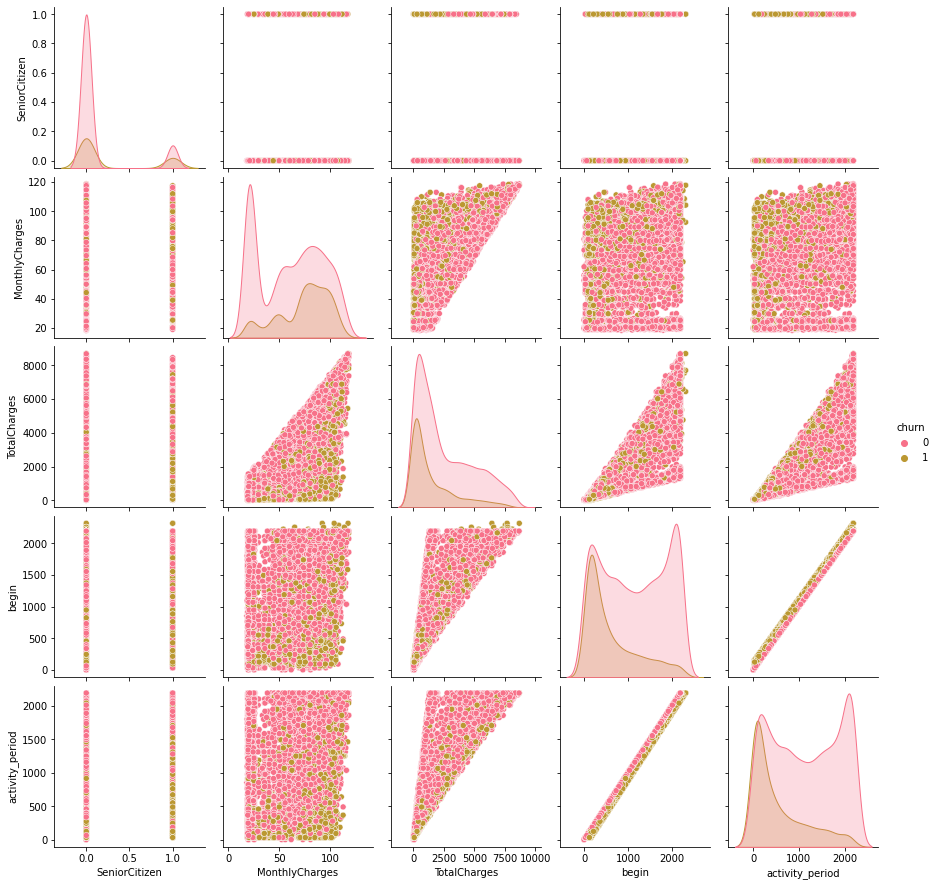

In [ ]:
sns.set_palette('husl')
sns.pairplot(df,hue='churn')

Видим, что ежемесячные траты и общая сумма потраченных денег на услуги для тех клиентов, которые остались, отличается, поэтому изучим эти признаки отдельно.

Построим диаграммы размаха ежемесячных и общих трат на услуги каждого типа клиентов.

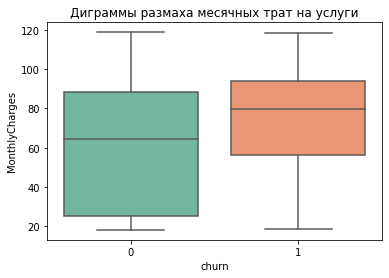

In [ ]:
sns.set_palette('Set2')
sns.boxplot(x = df['churn'], y = df['MonthlyCharges'])
plt.title('Диграммы размаха месячных трат на услуги')
plt.show()

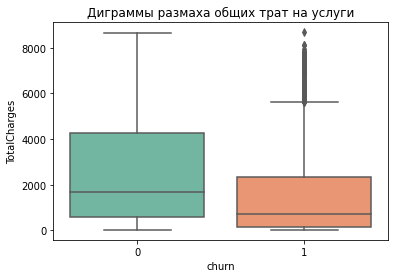

In [ ]:
sns.boxplot(x = df['churn'], y = df['TotalCharges'])
plt.title('Диграммы размаха общих трат на услуги')
plt.show()
#У клиентов,которые покинули компанию, появилисьвыбросы-возможно клиенты ушли, за услуги какое-то время деньги списывались у них, и в какой-то момент они отказались от услуг

Оценим статистические характеристики каждого класса клиентов

In [ ]:
#query-срез данных, в скобках необходимо указывать условия отбора данных
df0=df.query('churn == 0')
df1 = df.query('churn == 1')

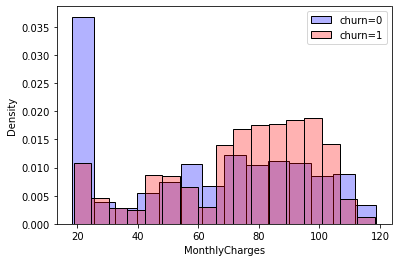

In [ ]:
#Рисуем графики распределения плотности вероятности. Наиболее актуальный график - histplot
#так как классы несблансиованы (одних объектов больше других в 3 раза)=> лучше вводить не количество. а плотность распределения вероятностей(т.е.относительный показатель)
sns.histplot(df0['MonthlyCharges'],stat = 'density', alpha = 0.3, color = 'b', label = 'churn=0')
sns.histplot(df1['MonthlyCharges'],stat = 'density', alpha = 0.3, color = 'r', label = 'churn=1')

#Метод best найдет наиболее пустое место на графике и располоит там подписи

plt.legend(loc = 'best')
plt.show()

#Месячные платежи имеют одинаковую форму от 60-70 до 120 - эта зона аиболее плотная
#Для клиентов неотточных наиболее весемы маленькие суммы: 20 едениц-наиболее встречающееся значение



Видно, что ежемесячные платежи заметно отличаются в двух группах.


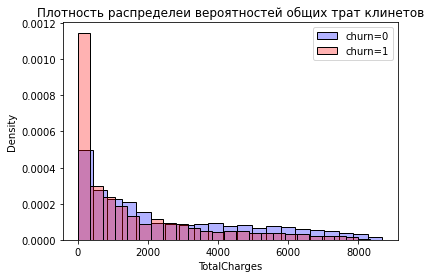

In [ ]:
sns.histplot(df0['TotalCharges'],stat = 'density', alpha = 0.3, color = 'b', label = 'churn=0')
sns.histplot(df1['TotalCharges'],stat = 'density', alpha = 0.3, color = 'r', label = 'churn=1')
plt.legend(loc = 'best')
plt.title('Плотность распределеи вероятностей общих трат клинетов')
plt.show()

Видим, что среднее и медианное значение ежемесячных трат на услуги у клиентов, которые ушли, выше. Хотя совокупные траты на услуги для клиентов, которые остались, существенно выше. Возможно, уход этих клиентов связан с большими месячными тратами на услуги, которые были подключены, но клиентами не ииспользовались. Возможно, ушедшие клиенты - это клиенты, которые были подключены относительно недавно, поэтому общие траты ниже, чем для оставшихся клиентов. Средний период активности ушедших клиентов составляет 547 дней, в то время как медиана периода активности - 304 дня, т.е. большинство ушедших клиентов являются клиентами данной телеком компании около одного года. При этом следует обратить внимание на очень большое ср.кв. отклонение периода активности, которое составляет для ушедших клиентов 594 дня. 25% ушедших клиентов ушли через 2 месяца пользования услугами. Есть среди ушедших клиентов и те, кто пользовался услугами телеком очень длительный период. 75%-ый квантиль составляет 883 дня, т.е. почти 3 года, а максимальный период активности ушедших клиентов - 6 лет. Тем не менее среди ушедших клиентов 25% составляют клиенты телекома, которые были лояльны более двух лет.

Для оценки периода активности не ушедших клиентов следует вернуться к дате их подключения.

Построим гистограммы распределения количества дней с момента подключения к услугам клиентов каждого типа и периода активности.

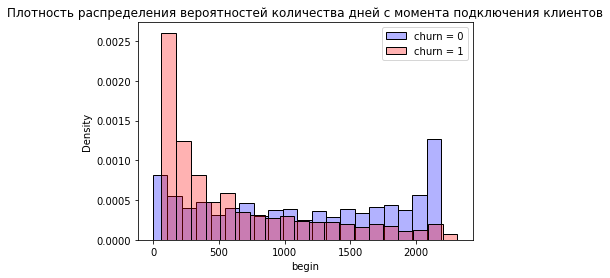

In [ ]:
figsize=(16, 6)
sns.histplot(df0['begin'], bins = 20, color = 'b', stat = 'density', alpha = 0.3, label ='churn = 0')
sns.histplot(df1['begin'],  bins = 20, color = 'r', stat = 'density', alpha = 0.3, label ='churn = 1')
plt.title('Плотность распределения вероятностей количества дней с момента подключения клиентов')
plt.legend(loc = 'best')
plt.show()

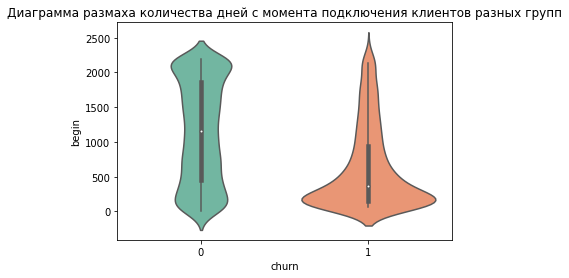

In [ ]:
sns.violinplot(x=df['churn'], y=df['begin'])
plt.title('Диаграмма размаха количества дней с момента подключения клиентов разных групп')
plt.show()

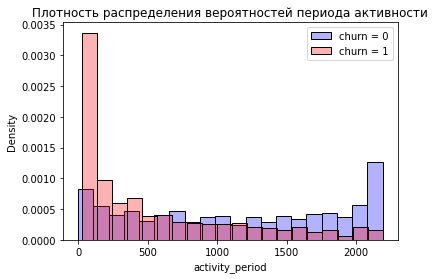

,SeniorCitizen,MonthlyCharges,TotalCharges,churn,begin,activity_period
count,5174.000000,5174.000000,5174.000000,5174.0,5174.000000,5174.000000
mean,0.128721,61.265124,2549.999497,0.0,1144.447236,1144.447236
std,0.334923,31.092648,2329.858843,0.0,733.897937,733.897937
min,0.000000,18.250000,18.800000,0.0,0.000000,0.000000
25%,0.000000,25.100000,572.900000,0.0,457.000000,457.000000
50%,0.000000,64.425000,1679.525000,0.0,1157.000000,1157.000000
75%,0.000000,88.400000,4262.850000,0.0,1857.000000,1857.000000
max,1.000000,118.750000,8672.450000,0.0,2191.000000,2191.000000


In [ ]:
figsize=(16, 6)
sns.histplot(df0['activity_period'], bins = 20, color = 'b', stat = 'density', alpha = 0.3, label ='churn = 0')
sns.histplot(df1['activity_period'],  bins = 20, color = 'r', stat = 'density', alpha = 0.3, label ='churn = 1')
plt.title('Плотность распределения вероятностей периода активности')
plt.legend(loc = 'best')
plt.show()
df0.describe()

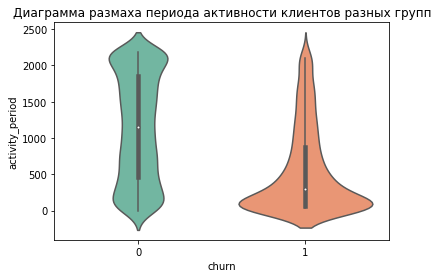

In [ ]:
sns.violinplot(x=df['churn'], y=df['activity_period'])
plt.title('Диаграмма размаха периода активности клиентов разных групп')
plt.show()

Видим, что для ушедших клиентов характерен небольшой срок давности подключения. Среди оставшихся клиентов примерно одинаковое количество подключенных несколько дней назад и достаточно давно. При этом достаточно много клиентов, дата подключения которых более 2000 дней назад. Для ушедших клиентов распределение периода подключения похоже на экспоненциальное, т.е. для большого количества клиентов более характерны небольшие периоды, т.е. в большинстве это новые клиенты, подключенные около 1-1.5 лет назад.

Оценим, какими услугами преимущественно пользуются клиенты каждой группы, какие предпочитают способы оплаты, тарифы, какого они преимущественно пола и пенсионного статуса. 

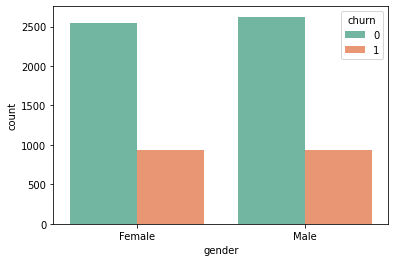

In [ ]:
sns.countplot(x = df['gender'], hue = df['churn'])
plt.show()

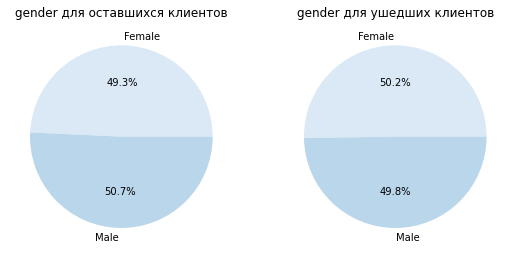

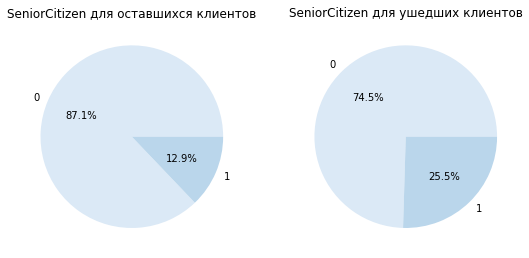

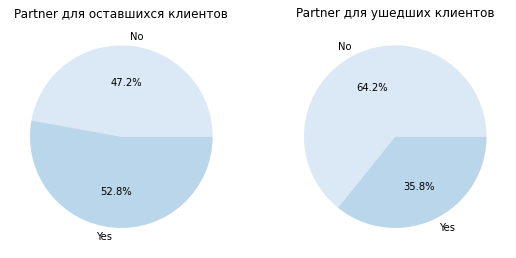

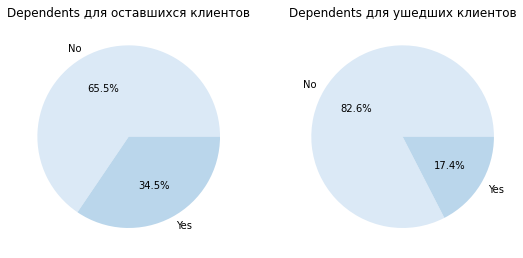

In [ ]:
feature = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

for name in feature:
    f0 = df0.groupby(name)['churn'].count()
    f1 = df1.groupby(name)['churn'].count()
    
    sns.set_palette('Blues')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
    ax1.set_title(name+ ' для оставшихся клиентов')
    ax1.pie(f0.values, labels=f0.index, autopct='%1.1f%%')  
    ax2.set_title(name+ ' для ушедших клиентов')
    ax2.pie(f1.values, labels=f1.index, autopct='%1.1f%%')  
    plt.show()
    

Видим, что доля мужчин и женщин как среди оставшихся, так и среди ушедших клиентов примерно одинаковая. Поэтому этот признак, скорее всего мало оказывает влияния на целевой фактор.

Как среди оставшихся, так и среди ушедших клиентов преобладают клиенты без статуса пенсионеров по возрасту. Среди ушедших доля клиентов пенсионеров почти в 2 раза превышает долю пенсионеров для оставшихся клиентов и составляет 25.5%

Для 64.2% клиентов, которые ушли, отсутствует супруг, в то время как для оставшихся клиентов только 47.2% супруга не имеют.


Для всех клиентов характерно отсутствие иждивенцев, но для ушедших клиентов их доля существенно выше, чем для оставшихся клиентов, и составляет 82.6% против 65.5%.

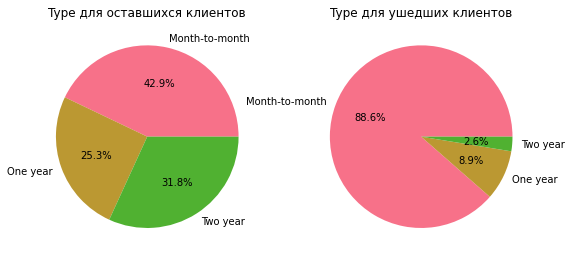

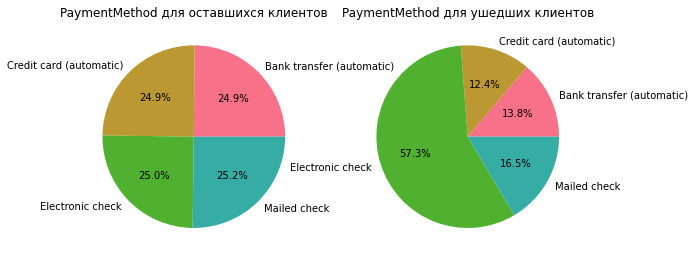

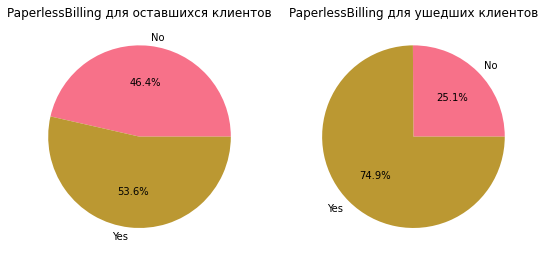

In [ ]:
feature = ['Type', 'PaymentMethod', 'PaperlessBilling']

for name in feature:
    f0 = df0.groupby(name)['churn'].count()
    f1 = df1.groupby(name)['churn'].count()
    
    sns.set_palette('husl')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
    ax1.set_title(name+ ' для оставшихся клиентов')
    ax1.pie(f0.values, labels=f0.index, autopct='%1.1f%%')  
    ax2.set_title(name+ ' для ушедших клиентов')
    ax2.pie(f1.values, labels=f1.index, autopct='%1.1f%%')  
    plt.show()

Для ушедших клиентов наиболее характерен помесячный тип оплаты. Доля таких клиентов составила почти 88.6%, для оставшихся клиентов такой способ оплаты выбирают 42.9%. Оплату за два года среди ушедших выбрали только 2.6%, в то время как среди оставшихся такой формат оплаты предпочли 31.8%. 

Для оставшихся клиентов все четыре способа оплаты одинаково предпочтительны, т.е. примерно одинаковое количество клиентов используют автоматические переводы с кредитных карт, автоматический банковский перевод, электронную оплату и оплату по почте. Для ушедших клиентов наиболее предпочтительным является электронная оплата, этот способ оплаты выбирает более 57% клиентов. Наименее популярным способом оплаты услуг для ушедших клиентов является автоматическая оплата кредитной картой.

Для всех клиентов более предпочтителен безналичный расчет. Однако для ушедших клиентов этот способ расчета выбирают около 75% клиентов, в то время как для оставшихся клиентов доля предпочитающих безналичный расчет составляет около 54%.

Оценим долю пользователей телефонной связи и интернета.

In [ ]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'churn', 'begin', 'activity_period'],
      dtype='object')

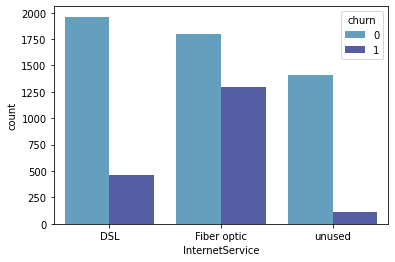

In [ ]:
sns.set_palette('icefire')
sns.countplot(x = df['InternetService'], hue = df['churn'])
plt.show()

Среди ушедших клиентов большинство были подключены по оптоволокну. Почти в три раза меньше ушедших клиентов, которые использовали технологию DSL, а среди тех, кто ушел, доля не пользовавшихся интернетом незначительна.

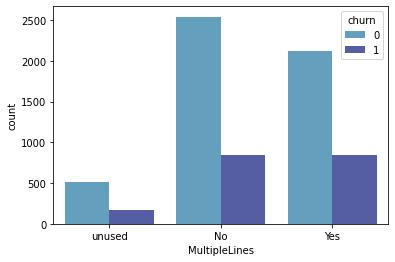

In [ ]:
sns.set_palette('icefire')
sns.countplot(x = df['MultipleLines'], hue = df['churn'])
plt.show()

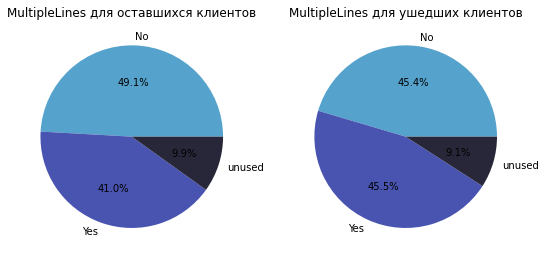

In [ ]:
f0 = df0.groupby('MultipleLines')['churn'].count()
f1 = df1.groupby('MultipleLines')['churn'].count()
    
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
ax1.set_title('MultipleLines для оставшихся клиентов')
ax1.pie(f0.values, labels=f0.index, autopct='%1.1f%%')  
ax2.set_title('MultipleLines для ушедших клиентов')
ax2.pie(f1.values, labels=f1.index, autopct='%1.1f%%')  
plt.show()

Для ушедших клиентов примерно одинаковое количество тех, кто использовал возможности ведения параллельных линий во время звонка и не использовал. Для оставшихся клиентов доля использующих такую возможность составляет 41.0% против 45.5% для ушедших клиентов. Разница в пропорциях достаточно незначительная, поэтому, скорее всего, этот признак не является значимым для прогнозирования оттока клиентов. 

Таким образом, видим, что выделенные классы клиентов имеют существенные отличия по большинству изученных показателей. Т.е. все категориальные признаки могут быть полезными для задачи прогнозирования оттока клиентов. Изучим корреляционную зависимость между признаками и целевым фактором.

### Изучение корреляционных связей

Идентификатор пользователя нам больше не пригодится, поэтому эти сведения удалим из датасета. Также исключим вспомогательный столбец `begin`. 

In [ ]:
df = df.drop(['customerID', 'begin'], axis = 1)

Наиболее тесная линейная связь между оттоком клиентов и периодом активности с коэффициентом корреляции -0.35. При этом видим более тесную прямую линейную связь между общими тратами и ежемесячными тратами (коэффициент корреляции 0.65), а также между периодом активности и общими тратами (коэффициент корреляции 0.82), что вполне логично.

In [ ]:
phik_overview = df.phik_matrix().round(2)
phik_overview

interval columns not set, guessing: ['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'churn', 'activity_period']


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn,activity_period
gender,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.00,1.00,0.02,0.32,0.09,0.24,0.29,0.30,0.15,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.09,0.23,0.03
Partner,0.00,0.02,1.00,0.65,0.18,0.01,0.24,0.20,0.42,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.09,0.23,0.49
Dependents,0.00,0.32,0.65,1.00,0.15,0.17,0.22,0.18,0.11,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.01,0.25,0.21
Type,0.00,0.09,0.18,0.15,1.00,0.11,0.28,0.39,0.51,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.24,0.25,0.66
PaperlessBilling,0.00,0.24,0.01,0.17,0.11,1.00,0.37,0.47,0.21,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.10,0.30,0.00
PaymentMethod,0.00,0.29,0.24,0.22,0.28,0.37,1.00,0.40,0.35,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.17,0.45,0.38
MonthlyCharges,0.01,0.30,0.20,0.18,0.39,0.47,0.40,1.00,0.76,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.71,0.36,0.41
TotalCharges,0.00,0.15,0.42,0.11,0.51,0.21,0.35,0.76,1.00,0.51,0.54,0.66,0.67,0.57,0.66,0.67,0.49,0.28,0.84
InternetService,0.00,0.16,0.00,0.11,0.51,0.23,0.32,0.92,0.51,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.74,0.20,0.02


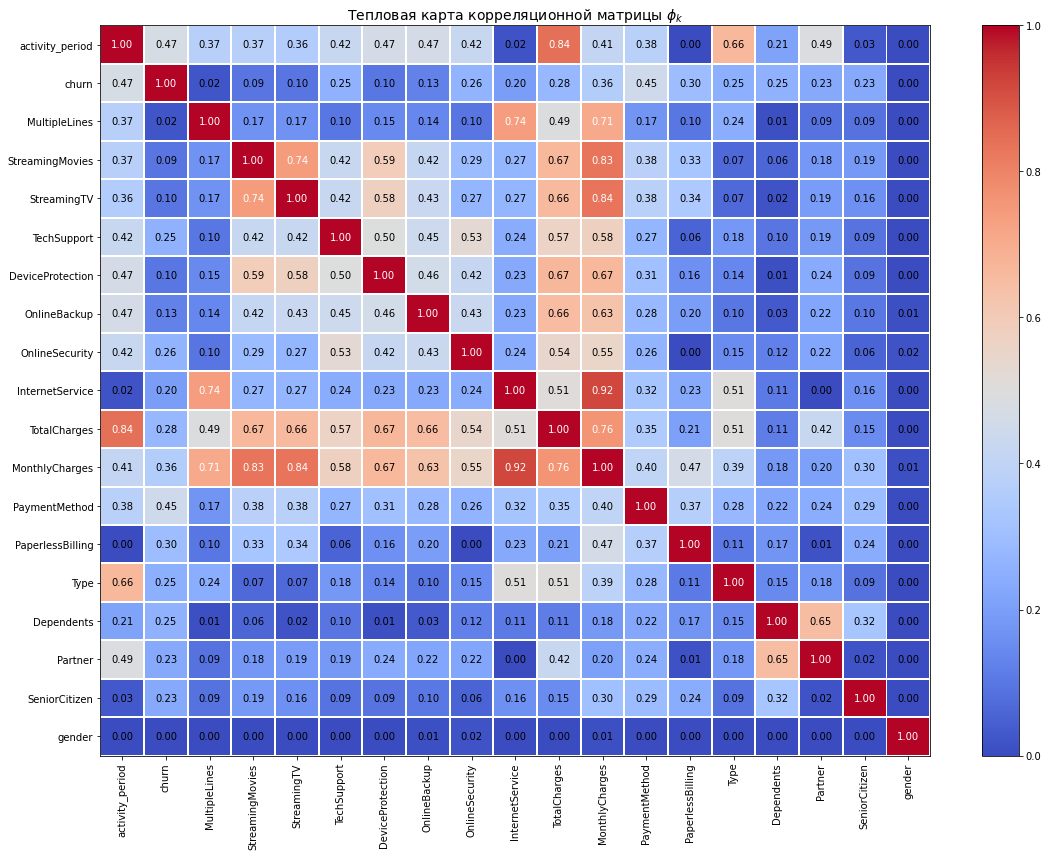

In [ ]:
interval_cols = ['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'churn', 'begin', 'activity_period']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='coolwarm', 
                        title= 'Тепловая карта корреляционной матрицы $\phi_k$', 
                        figsize=(16, 12))
plt.tight_layout()

Видим наличие корреляции между оттоком клиентов и периодом активности.

Также достаточно высокие значения корреляции между значениями ежемесячных трат на услуги и признаками, характеризующими услуги, которые по всей видимости и были оплачены ежемесячно. Схожая картина с вывокой корреляцией наблюдается и для общих трат на услуги и самими услугами.

Также высокая корреляция между общими тратами и количеством дней с момента подключения клиента.

Оценим статистическую значимость коэффициентов корреляции.

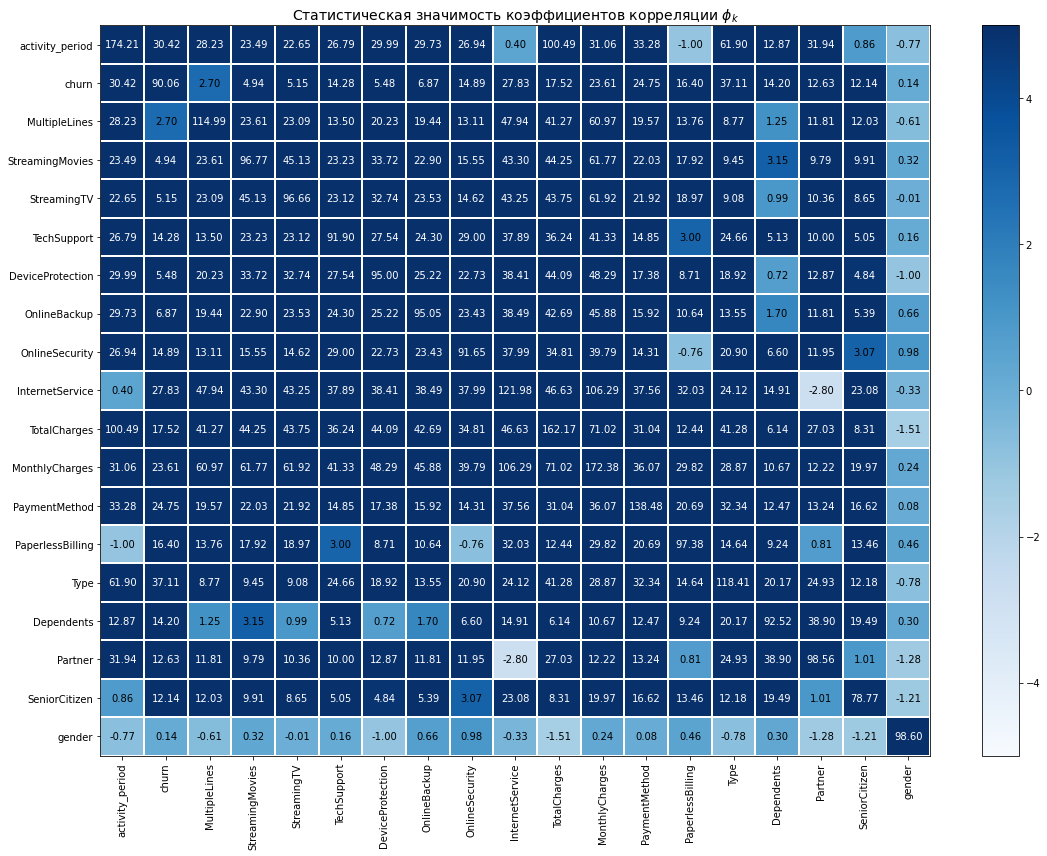

In [ ]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Статистическая значимость коэффициентов корреляции $\phi_k$", 
                        color_map='Blues', usetex=False, figsize=(16, 12))
plt.tight_layout()

Наименее значимой можно считать корреляцию между признаком пола клиента и всеми остальными признаками. 

Оценим глобальный коэффициент корреляции

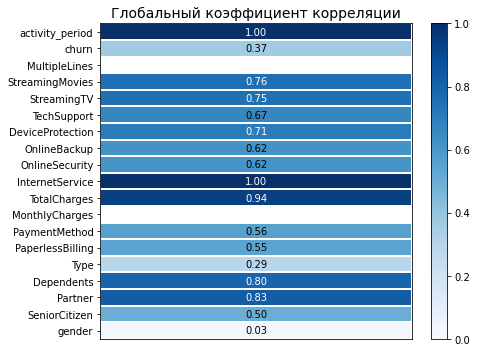

In [ ]:
global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1,
                        color_map='Blues', title='Глобальный коэффициент корреляции')
plt.tight_layout()

Многие переменные имеют довольно высокие значения глобальной метрики корреляции, самое высокое значение которой составляет `activity_period`, `InternetService`, `TotalCharges`, `Partner` и `Dependents`. Т.е. целевой признак можно представить через остальные признаки достаточно полно.

Можно наименее информативные признаки удалить. Но обычно высокая корреляция категориальных признаков — это пища для размышлений, тем не менее можно обучить модель и с этими признаками, а затем исследовать важность признаков в модели (feature_importances). Анализ важности признаков - это мощный инструмент для отбора признаков, его можно рассмотреть в паре с корреляциями.
    
Стоит отметить, что у нас есть еще пара числовых признаков с высокой взаимной корреляцией. Некоторые модели, например линейная регрессия, чувствительны к мультиколлинеарности, поэтому этот момент нужно исключать, либо добавить регуляризаторы в модель.


Для исключения взаимного влияния прикнаков друг на друга и снижения их совокупного усиленного влияния на целевой признак, удалим `TotalCharges`. 

In [ ]:
# Удалим неинформативные признаки.


## Этап 3. Обучение и тестирование моделей ML

### Подготовка данных

In [ ]:
# Создадим переменные для признаков features и целевого признака target
target=df['churn']
features=df.drop(['churn'],axis=1)
#axis=1 - удаляется столбец

In [ ]:
features_train, features_test,target_train, target_test=train_test_split(features,target,test_size=0.25,random_state=140223,stratify=target,shuffle=True)
print('Размерность обучающего набора',features_train.shape)
print('Размерность тестовой выборки',features_test.shape)

Размерность обучающего набора (5282, 18)
Размерность тестовой выборки (1761, 18)


Линейные и метрические модели достаточно чувствительны к выбросам, поэтому количественные признаки лучше стандартизировать. 

Для масштабирования и кодирования зафиксируем количественные признаки и категориальные

In [ ]:
numeric = ['MonthlyCharges', 'activity_period'] 
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type',
       'PaperlessBilling', 'PaymentMethod','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [ ]:
for name in categorical:
    features_train[name] = features_train[name].astype('category')

In [ ]:
# Порядковое кодирование категориальных признаков для деревянных моделей.
# Модели, построенные на основе решающих деревьев, не чувствительны к выбросам, поэтому стандартизацию количественных признаков делать не нужно
features_train_cat=features_train.copy()
ord_enc=OrdinalEncoder()
features_train_cat[categorical]=ord_enc.fit_transform(features_train_cat[categorical])
features_train_cat.head()

#ordinalEncoder


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,activity_period
2363,1.0,0.0,0.0,0.0,0.0,1.0,2.0,44.75,44.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31
5155,0.0,0.0,0.0,0.0,1.0,1.0,0.0,94.40,2638.10,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,914
1374,1.0,0.0,1.0,1.0,2.0,1.0,3.0,84.35,3858.05,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1371
6212,1.0,0.0,0.0,0.0,1.0,0.0,2.0,50.75,688.20,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,457
2135,0.0,0.0,0.0,0.0,0.0,1.0,1.0,106.60,5893.95,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1706


In [ ]:
# Стандартизация количественных признаков
features_train_num= features_train[numeric]
scaler=StandardScaler()
scaler.fit(features_train_num)
features_train_num=pd.DataFrame(scaler.transform( features_train_num), columns =features_train_num.columns)

In [ ]:
# Кодирование категориальных признаков методом OHE
ohe_enc=OneHotEncoder(drop = 'first')
ohe_enc.fit(features[categorical])
ohe_features=ohe_enc.get_feature_names(categorical)
features_train_ohe=pd.DataFrame(ohe_enc.transform(features_train[categorical]).toarray(),columns=ohe_features)

In [ ]:

features_train_ohe=features_train_ohe.join(features_train_num.reset_index())


In [ ]:
features_train_ohe.columns

Index(['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_unused',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'MultipleLines_Yes', 'MultipleLines_unused', 'index', 'MonthlyCharges',
       'activity_period'],
      dtype='object')

In [ ]:

features_train_ohe=features_train_ohe.drop(['index'],axis=1)

In [ ]:

features_train_ohe.head()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MultipleLines_unused,MonthlyCharges,activity_period
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.678502,-1.283407
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.972460,-0.100362
2,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.638278,0.511927
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-0.478990,-0.712651
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.378134,0.960761


In [ ]:
cv=StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=210223)



### Обучение и оценка адекватности моделей ML

#### KNN Classifier

In [ ]:
param_grid={'n_neighbours':[5,7,9,11,13,15],
            'weights': ['uniform','distance']}




In [ ]:
knn_model=GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring= 'roc_auc', n_jobs=-1)      

In [ ]:
knn_model.fit(features_train_ohe, target_train)

ValueError: ignored

In [ ]:
print('параметры лучшей модели', knn_model.best_params_)

AttributeError: ignored

In [ ]:
Results = pd.DataFrame({'Model' : 'KNN',
                       'ROC-AUC score valid' : knn_model.best_score_,
                       'Fit time': knn_model.cv_results_["mean_fit_time"][knn_model.best_index_]
                        }, index=[0])

#### LogisticRegression

In [ ]:
param_grid={'C':[0.01, 0.05, 0.1, 0.5, 1 , 5, 10]}


In [ ]:
lr_model=GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced'), param_grid, cv=cv, scoring = 'roc_auc', n_jobs = -1)

In [ ]:
lr_model.fit(features_train_ohe, target_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=210223, test_size=0.1,
            train_size=None),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             n_jobs=-1, param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='roc_auc')

In [ ]:
Results = Results.append({'Model' : 'Logistic Regression',
                       'ROC-AUC score valid' : lr_model.best_score_,
                       'Fit time': lr_model.cv_results_["mean_fit_time"][lr_model.best_index_]
                        }, ignore_index=True)

NameError: ignored

### Decision Tree

In [ ]:
param_grid = {'max_depth' : range(4, 21, 22)}

In [ ]:
idSearchCV(DecisionTreeClassifier(class_weight='balanced'), random_state = 210223, cv = cv, scoring = 'roc_auc', n_jobs = -1)


NameError: ignored

In [ ]:
DT_model.fit(features_train_cat, target_train)

NameError: ignored

In [ ]:
Results = Results.append({'Model' : 'Decision Tree',
                       'ROC-AUC score valid' : DT_model.best_score_,
                       'Fit time': DT_model.cv_results_["mean_fit_time"][DT_model.best_index_]
                        }, ignore_index=True)

In [ ]:
# Важность признаков
feature_imp = pd.Series(DT_model.best_estimator_.feature_importances_, index = features_train.columns).sort_values(ascending = False)
feature_imp.head(10)

In [ ]:
sns.barplot(x= feature_imp, y = feature_imp.index)
plt.xlabel("Важности признаков")
plt.ylabel("Признаки")
plt.show()

Наиболее важными для классификации оказались признаки: тип оплаты, период активности, ежемесячные траты на услуги и использование интернета

#### Random Forest

In [ ]:
param_grid={'n_estimators': [50, 100, 125, 150, 200, 250, 300],
            'max_depth': range(6, 12, 2)}

In [ ]:
RF_model = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=210223, cv = cv, scoring = 'roc_auc', n_jobs = -1))

TypeError: ignored

In [ ]:
RF_model.fit(features_train_cat, target_train)

NameError: ignored

In [ ]:
Results = Results.append({'Model' : 'Random Forest',
                       'ROC-AUC score valid' : RF_model.best_score_,
                       'Fit time': RF_model.cv_results_["mean_fit_time"][RF_model.best_index_]
                        }, ignore_index=True)

In [ ]:
# Важность признаков
feature_imp = pd.Series(RF_model.best_estimator_.feature_importances_, index = features_train.columns).sort_values(ascending = False)
feature_imp

In [ ]:
sns.barplot(x= feature_imp, y = feature_imp.index)
plt.xlabel("Важности признаков")
plt.ylabel("Признаки")
plt.show()

Для алгоритма случайного леса наиболее важными для классификации оказались признаки: период активности, тип оплаты, ежемесячные траты на услуги, использование интернета, способ оплаты. 

#### LGBM 

In [ ]:
param_grid={'n_esrimators': [50, 100, 125, 150, 200, 250, 300],
            'max_depth': range(6, 12, 2),
            'learning_rate': [0.01,0.05, 0.1, 0.15, 0.2, 0.25 ]}

In [ ]:
LGBM_model=GridSearchCV(LGBMClassifier(class_weight='balanced',random_state=210223, cv=cv, scoring='roc_auc', n_jobs= -1))

TypeError: ignored

In [ ]:

LGBM_model.fit(features_train_cat, target_train)

In [ ]:
Results = Results.append({'Model' : 'LGBM',
                       'ROC-AUC score valid' : LGBM_model.best_score_,
                       'Fit time': LGBM_model.cv_results_["mean_fit_time"][LGBM_model.best_index_]
                        }, ignore_index=True)

In [ ]:
# Важность признаков
feature_imp = pd.Series(LGBM_model.best_estimator_.feature_importances_, index = features_train.columns).sort_values(ascending = False)
feature_imp

In [ ]:
sns.barplot(x= feature_imp, y = feature_imp.index)
plt.xlabel("Важности признаков")
plt.ylabel("Признаки")
plt.show()

Для алгоритма `LightGBM` наиболее важными для классификации оказались признаки: период активности, ежемесячные траты на услуги, тип оплаты, пол клиента, способ оплаты.

#### CatBoost

In [ ]:
param_grid= {'depth': range(4,10), 
             'n_stimators': [50, 100, 125, 150, 200, 250, 300],
             'learning_rate': [0.01,0.05, 0.1, 0.15, 0.2, 0.25 ]}


In [ ]:
CatBoost_model = GridSearchCV(CatBoostClassifier(random_state=210223, cat_features=categorical, iterations=1100 , cv = cv, scoring='roc_auc', n_jobs= -1 ))

TypeError: ignored

In [ ]:
CatBoost_model.fit(features_train, target_train)

NameError: ignored

In [ ]:
Results = Results.append({'Model' : 'CatBoost',
                       'ROC-AUC score valid' : CatBoost_model.best_score_,
                       'Fit time': CatBoost_model.cv_results_["mean_fit_time"][CatBoost_model.best_index_]
                        }, ignore_index=True)

In [ ]:
# Важность признаков
feature_imp = pd.Series(CatBoost_model.best_estimator_.feature_importances_, index = features_train.columns).sort_values(ascending = False)
feature_imp

In [ ]:
sns.barplot(x= feature_imp, y = feature_imp.index)
plt.xlabel("Важности признаков")
plt.ylabel("Признаки")
plt.show()

Для алгоритма CatBoost наиболее важными для классификации оказались признаки: период активности, ежемесячные траты на услуги, тип оплаты.

Анализ важности признаков позволяет не только построить лучшую модель и уменьшить число признаков для обучения. Мы также можем выдать рекомендации бизнесу, изучив влияние признаков на отток, тем самым можно повысить качество определенных услуг, например онлайн-платежи или интернет на оптоволокне.


### Сравнение результатов

In [ ]:
 Results

Видим, что модель k-ближайших соседей имеет наименьшее время обучения, но метрика ROC-AUC для этой модели на валидационной выборке оказалось минимальной среди метрик всех рассмотренных моделей. Для всех моделей метрика ROC-AUC > 0.82. Наилучший результат качества обучения имеет алгоритм CatBoost, но обучение длилось немного дольше, чем для LightGBM Classifier. На основании полученных результатов, делаем вывод, что наиболее оптимальной моделью среди рассмотренных моделей бинарной классификации является модель CatBoost.

### Оценка адекватности модели

In [ ]:
dummy_model = DummyClassifier(strategy="most_frequent", random_state = 141122)
ROC_AUC = cross_val_score(dummy_model, features_train, target_train, cv = cv, scoring = 'roc_auc', n_jobs = -1) 

print('ROC-AUC на валидационной выборке константной модели: ', ROC_AUC.mean())

Учитывая существенное преобладание объектов класса 0 в исходных данных, обощающую способность всех построенных моделей можно считать хорошей, все модели можно считать адекватными.

### Проверка на тестовом наборе

In [ ]:
model_pred = CatBoost_model.best_estimator_.predict(features_test)
# на данный момент модель LGBM оказалась лучшей 


In [ ]:
print('Accuracy на тестовом наборе', accuracy_score(target_test))
print('F-мера на тестовом наборе')
print('ROC_AUC на тестовом наборе')

In [ ]:
conf_matrix = confusion_matrix(target_test, model_pred)

sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd')
print(classification_report(target_test, model_pred))

In [ ]:
# ROC-кривая построенной модели
plot_roc_curve(CatBoost_model.best_estimator_, features_test, target_test, name='CatBoost')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC-кривая модели CatBoost')
plt.show()

In [ ]:
# Кривая Precision-Recall
probabilities_test = CatBoost_model.best_estimator_.predict_proba(features_test)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Кривая Precision-Recall')
plt.show() 

### Выводы

По результататм тестирования "лучшей" модели делаем вывод о достаточно хорошей обощающей способности модели. На тестовом наборе метрика `accuracy` составляет 0.88, `F-мера` равна 0.75, значение `roc-auc` составило 0.93, что говорит о хорошем качестве построенного классификатора. Однако на тестовом наборе данных значение Recall для объектов класса 1 составляет 0,67, т.е. 67% ушедших клиентов идентифицированы моделью верно. Это связано в первую очередь с тем, что общее количество таких пользователей составляет менее 1/3 от общего числа клиентов.
